In [1]:
import os
os.getcwd()

'C:\\Users\\DJ COMPUTERS'

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [133]:
data = pd.read_csv("cleaned_data.csv")
data.head()

,date,category,amount
0,01/01/2021,Education,3888.0
1,01/01/2021,Utilities,5767.0
2,01/01/2021,Utilities,4262.0
3,01/01/2021,Others,59543.0
4,01/01/2021,Utilities,5070.0


In [129]:
data['amount'].mean()

5080503.343211832

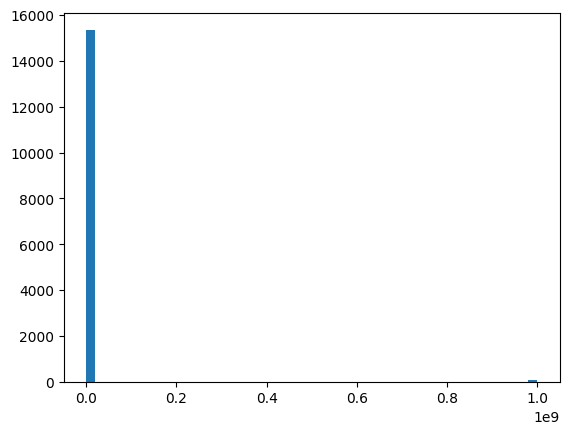

In [135]:
import matplotlib.pyplot as plt
plt.hist(data['amount'], bins=50)
plt.show()


In [91]:
import pandas as pd

def group_daily_expense(df, date_col='date', amount_col='amount'):
   
    # Convert date column to datetime
    df[date_col] = pd.to_datetime(df[date_col], format="%d/%m/%Y", errors='coerce')
    
    # Drop invalid dates (if any)
    df = df.dropna(subset=[date_col])
    
    # Group by date and sum expenditures
    daily_expense = df.groupby(date_col, as_index=False)[amount_col].sum()
    
    # Sort by date and set date as index (for time series use)
    daily_expense = daily_expense.sort_values(date_col).set_index(date_col)
    
    return daily_expense


In [93]:
# Assuming your DataFrame is named 'data'
daily_expense = group_daily_expense(data)

print(daily_expense.head())


                  amount
date                    
2021-01-01  1.000167e+09
2021-01-02  1.009070e+06
2021-01-03  1.074411e+06
2021-01-04  6.022100e+04
2021-01-05  9.159056e+04


In [95]:
daily_expense.tail(10)

,amount
date,
2024-12-22,3.622761e+05
2024-12-23,2.415986e+05
2024-12-24,1.102145e+06
2024-12-25,2.471914e+04
2024-12-26,6.466557e+04
2024-12-27,1.177913e+06
2024-12-28,1.814960e+05
2024-12-29,1.071120e+05
2024-12-30,7.090100e+04


In [97]:
daily_expense.shape

(1461, 1)

In [137]:
# Importing necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [141]:
# log1p to handle zeros safely
daily_expense['log_amount'] = np.log1p(daily_expense['amount'])

In [143]:
# Train-Test Splitting
n = len(daily_expense)
train_size = int(n * 0.8)
train_ts = daily_expense.iloc[:train_size].copy()
test_ts  = daily_expense.iloc[train_size:].copy()

print(f"Total days: {n}, Train days: {len(train_ts)}, Test days: {len(test_ts)}")


Total days: 1461, Train days: 1168, Test days: 293


In [145]:
# Auto-select (p,d,q) while using d=None or set d=0 if you already tested stationarity
print("\n=== Running auto_arima on the log target (this may take a moment) ===")
auto_model = auto_arima(
    train_ts['log_amount'],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    seasonal=False,
    stepwise=True,
    trace=False,
    error_action='ignore',
    suppress_warnings=True
)

print("Selected order (p,d,q):", auto_model.order)


=== Running auto_arima on the log target (this may take a moment) ===
Selected order (p,d,q): (0, 0, 0)


In [147]:
# Fit final ARIMA on train log series using statsmodels for forecasting API consistency
p, d, q = auto_model.order
arima_model = ARIMA(train_ts['log_amount'], order=(p, d, q))
arima_fit = arima_model.fit()

In [149]:

# Forecast on test horizon (predict in log-space)
n_test = len(test_ts)
arima_fore_log = arima_fit.forecast(steps=n_test)
# invert log transform
arima_fore = np.expm1(arima_fore_log)

# Align forecast index with test
arima_fore = pd.Series(arima_fore, index=test_ts.index, name='arima_pred')


In [153]:
lags = 7
df_rf = daily_expense[['amount', 'log_amount']].copy()

In [155]:
# create lag features (log space)
for lag in range(1, lags+1):
    df_rf[f'lag_log_{lag}'] = df_rf['log_amount'].shift(lag)

In [157]:
# rolling statistics in log space
df_rf['rolling_mean_7'] = df_rf['log_amount'].rolling(window=7).mean().shift(1)  # use past 7-day mean
df_rf['rolling_std_7']  = df_rf['log_amount'].rolling(window=7).std().shift(1)

In [159]:
# date-derived features
df_rf['day_of_week'] = df_rf.index.dayofweek
df_rf['day'] = df_rf.index.day
df_rf['month'] = df_rf.index.month
df_rf['is_month_start'] = df_rf.index.is_month_start.astype(int)

# drop rows with NaNs created by shifting
df_rf = df_rf.dropna()

In [161]:
# split into train/test by index (time-based)
X = df_rf.drop(columns=['amount', 'log_amount'])
y = df_rf['log_amount']

X_train = X.loc[:train_ts.index[-1]]
y_train = y.loc[:train_ts.index[-1]]
X_test  = X.loc[test_ts.index[0]:]
y_test  = y.loc[test_ts.index[0]:]

print(f"\nRF features shape -> X_train: {X_train.shape}, X_test: {X_test.shape}")


RF features shape -> X_train: (1161, 13), X_test: (293, 13)


In [163]:
# train RandomForest on log target
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [165]:
# predict log target and invert
rf_pred_log = rf.predict(X_test)
rf_pred = np.expm1(rf_pred_log)
rf_pred = pd.Series(rf_pred, index=X_test.index, name='rf_pred')

In [167]:
y_true = test_ts['amount']

def eval_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = eval_metrics(y_true, arima_fore)
rf_mae, rf_rmse, rf_mape = eval_metrics(y_true, rf_pred)

print("\n=== Evaluation on test set ===")
print(f"ARIMA    -> MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape*100:.2f}%")
print(f"RandomFR -> MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, MAPE: {rf_mape*100:.2f}%")

# Baseline: naive yesterday forecast (shifted)
naive_pred = test_ts['amount'].shift(1).fillna(train_ts['amount'].iloc[-1])
base_mae, base_rmse, base_mape = eval_metrics(y_true, naive_pred)
print(f"Naive    -> MAE: {base_mae:.2f}, RMSE: {base_rmse:.2f}, MAPE: {base_mape*100:.2f}%")


=== Evaluation on test set ===
ARIMA    -> MAE: 44524661.55, RMSE: 210629788.38, MAPE: 136.66%
RandomFR -> MAE: 44547570.70, RMSE: 210601958.58, MAPE: 157.97%
Naive    -> MAE: 82139451.52, RMSE: 286201396.29, MAPE: 45528.34%


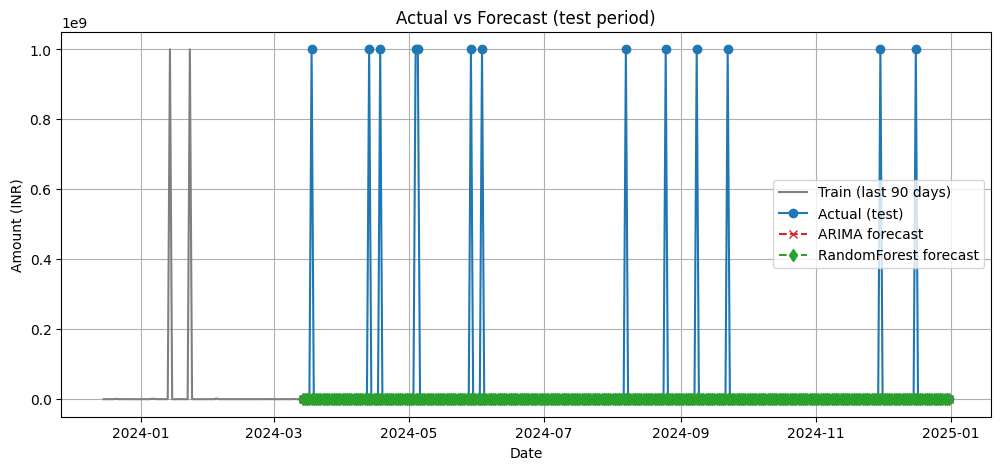

In [169]:
plt.figure(figsize=(12,5))
plt.plot(train_ts.index[-90:], train_ts['amount'].iloc[-90:], label='Train (last 90 days)', color='tab:gray')
plt.plot(test_ts.index, y_true, label='Actual (test)', color='tab:blue', marker='o')
plt.plot(arima_fore.index, arima_fore, label='ARIMA forecast', color='tab:red', linestyle='--', marker='x')
plt.plot(rf_pred.index, rf_pred, label='RandomForest forecast', color='tab:green', linestyle='--', marker='d')
plt.title('Actual vs Forecast (test period)')
plt.xlabel('Date')
plt.ylabel('Amount (INR)')
plt.legend()
plt.grid(True)
plt.show()
